# Capstone Project -- The Battle of Neighborhoods 

## Week 4 / 5 -- *Applied Data Science Capstone by IBM/Coursera*

## 0) Table of Contents

This is the final capstone project of the course Applied Data Science Capstone of the course circle
https://www.coursera.org/professional-certificates/ibm-data-science 

This notebook contains multiple parts:
   
Week 1:

 1) Problem description and background discussion 
    
 2) Data description and how the data will help to solve the problem 

Week 2:

 1 ) Methodology and Exploratory Data Analysis

 2 ) Discussion


## Week 1: 
### 1) Introduction and Discussion of the Business Objective and Problem

In this project we want to find a good location for a restaurant. Specifically, we are interested in opening an **American burger restaurant** in **Rome** the capital of Italy. Rome is the home of 3 mio people.

We are also particularly interested in areas with other burger restaurants in neighborhood. We would also prefer locations **as close to city center as possible**. Chosing the right location for business is one of the difficult and discussable tasks, since there are a lot of criteria to be considered in order to achieve the high revenue. 

We want to look at the following influencing factor:

 * the number of burger restaurants in the same zone
 * solvency of the population around the location
 

In this project, we will implement the basic analysis and try to find the most optimal neighborhood to open a burger restaurant according to those criteria. It's obvious, that there are many additional factors, such as distance from parking places or distance from the main streets, but this analysis can be done after choosing the Borough, and thus will not be done within the scope of this project.

Although there is a trend towards eating healthier food, burger restaurants still enjoy great popularity.

## 2) Data acquisition

### 2.1 Data source

* Geographical information
    * Wikipedia Data of Rome
    * Shapefile of Municipi di Roma: http://www.datiopen.it/it/opendata/Municipi_di_Roma_Capitale
    * Shapefile of Zone urbane: https://www.mapparoma.info/zone-urbanistiche/
* Restaurant type information
    * Foursquare API: selection of restaurants accourding to the category type and location

### 2.2 Feature selection


* Using Fourshquare to get all burger restaurant in Rome with attributes of ID, name, category (burger restaurant), gps coordinate
* Using Foursquare API

*Python packages*

In [1]:
import requests
import lxml.html as lh
import pandas as pd
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd
import geoplot
import os
from pyproj import Proj
from geopandas.tools import sjoin

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Week 2: Exploring Rome 

In [2]:
municipi_shape_full = gpd.read_file('Municipi_Roma_15_wgs84_1.shp')
municipi_shape_full['centroid'] = municipi_shape_full.centroid
municipi_geometry = municipi_shape_full[['municipio','zone_urb','geometry','centroid']].copy(deep=True)

In [3]:
def decode_roman_numeral(roman):
    """Calculate the numeric value of a roman letter"""
    trans = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    values = [trans[r] for r in roman]
    return sum(
        val if val >= next_val else -val
        for val, next_val in zip(values[:-1], values[1:])
    ) + values[-1]

In [4]:
def get_lat_lon(df,used_column,city):

    geolocator = Nominatim(user_agent="explorer")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=4)    

    # getting the latitude and longitude 
    # TAKES A LOT OF TIME DUE TO SLOW RESPONSE TIME OF GEOCODER and used delays for stability
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=3,error_wait_seconds=5)
    latitude=[]
    longitude=[]
    for zone_name in df[used_column]:
        zone_name_ext = zone_name + ',' +  city
        #lat_lng_coords = None
        #while(lat_lng_coords is None):
        location = geocode('{}'.format(zone_name_ext))  
        if location == None:
            print('')
            latitude.append(0)
            longitude.append(0)
        else:
            print(location)
            print(location[1][0])    
            print(location[1][1])
            latitude.append(location[1][0])    
            longitude.append(location[1][1])

    df.insert(len(df.columns),'Latitude',latitude)
    df.insert(len(df.columns),'Longitude',longitude)
    
    return df

In [5]:
municipiourl = r'https://en.wikipedia.org/wiki/Administrative_subdivision_of_Rome'
df_municipi_wiki = pd.read_html(municipiourl)[1]

In [6]:
df_municipi_wiki[['MunicipioNr','MunicipioName']] = df_municipi_wiki.Municipio.str.split("–",expand=True)
df_municipi_wiki.drop(['Map'],inplace=True,axis=1)
df_municipi_wiki['municipio'] = [str(decode_roman_numeral(n)) for n in df_municipi_wiki['MunicipioNr'].str.extract(r'Municipio\s?([XVI]+)', expand=False).tolist()]

In [7]:
df_municipi_wiki.head()

,Municipio,Population 31 December 2015,Area in km²,Density per km²,MunicipioNr,MunicipioName,municipio
0,Municipio I – Historical Center,186802,19.91,9382,Municipio I,Historical Center,1
1,Municipio II – Parioli/Nomentano,167736,19.60,8567,Municipio II,Parioli/Nomentano,2
2,Municipio III – Monte Sacro,204514,97.82,2091,Municipio III,Monte Sacro,3
3,Municipio IV – Tiburtina,177084,49.15,3603,Municipio IV,Tiburtina,4
4,Municipio V – Prenestino/Centocelle,246471,27.00,9137,Municipio V,Prenestino/Centocelle,5


In [8]:
df_municipi_comb = pd.merge(df_municipi_wiki,municipi_geometry,on='municipio')
df_municipi_comb.columns = ['Municipio','Population','Area','Density','MunicipioNr','MunicipioName','municipio','zone_urb','geometry','centroid']
df_municipi_comb['LatitudeCent'] = df_municipi_comb.centroid.apply(lambda p: round(p.y,7)).astype(float)
df_municipi_comb['LongitudeCent'] = df_municipi_comb.centroid.apply(lambda p: round(p.x,7)).astype(float)

In [9]:
df_municipi_comb.head()

,Municipio,Population,Area,Density,MunicipioNr,MunicipioName,municipio,zone_urb,geometry,centroid,LatitudeCent,LongitudeCent
0,Municipio I – Historical Center,186802,19.91,9382,Municipio I,Historical Center,1,"Centro Storico,Trastevere,Aventino,Testaccio,E...","POLYGON ((12.44396 41.93391, 12.44473 41.93212...",POINT (12.47795 41.89863),41.898628,12.477950
1,Municipio II – Parioli/Nomentano,167736,19.60,8567,Municipio II,Parioli/Nomentano,2,"Villaggio Olimpico,Parioli,Flaminio,Salario,Tr...","POLYGON ((12.50099 41.94215, 12.50117 41.94199...",POINT (12.50118 41.92070),41.920704,12.501180
2,Municipio III – Monte Sacro,204514,97.82,2091,Municipio III,Monte Sacro,3,"Montesacro,Val Melaina,Monte Sacro Alto,Fidene...","POLYGON ((12.56322 42.07465, 12.56270 42.07313...",POINT (12.55432 41.99644),41.996439,12.554324
3,Municipio IV – Tiburtina,177084,49.15,3603,Municipio IV,Tiburtina,4,"Casal Bertone,Casal Bruciato,Tiburtino Nord,Ti...","POLYGON ((12.63543 41.95729, 12.63697 41.95728...",POINT (12.59134 41.93216),41.932162,12.591343
4,Municipio V – Prenestino/Centocelle,246471,27.00,9137,Municipio V,Prenestino/Centocelle,5,"Torpignattara,Casilino,Quadraro,Gordiani,Cento...","POLYGON ((12.61539 41.89947, 12.61530 41.89640...",POINT (12.57557 41.88910),41.889105,12.575565


In [10]:
address_rome = 'Rome, Italia'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address_rome)
rome_latitude = location.latitude
rome_longitude = location.longitude
print('The geographical coordinates of Rome are {}, {}.'.format(rome_latitude, rome_longitude))

The geographical coordinates of Rome are 41.8933203, 12.4829321.


In [11]:
dfcut = df_municipi_comb[['Area','Density','geometry']].copy(deep=True)

In [12]:
rome_map = folium.Map(location=[rome_latitude, rome_longitude], zoom_start=10, tiles='CartoDB positron')

folium.Choropleth(
    geo_data=municipi_shape_full.drop('centroid',axis=1),
    fill_color='silver', 
    fill_opacity=0.6, 
    line_color='black',
    line_weight=2,
    ).add_to(rome_map)

locations = df_municipi_comb[['LatitudeCent','LongitudeCent']].values
names = df_municipi_comb['MunicipioName'].tolist()
nums = df_municipi_comb['municipio'].tolist()

for loc, num, name in zip(locations, nums, names):
    folium.Marker(loc, popup=folium.Popup('<center><b>Municipio ' + str(num) + '</b></br>' + name + '</center>')
        ).add_to(rome_map)
    
rome_map


In [13]:
df_zones = pd.read_html('https://fr.wikipedia.org/wiki/Zones_de_Rome')[0]
dfz1=df_zones[[0,1]] #.iloc [1:, [0, 1]]#.reset_index()
dfz2=df_zones[[2,3]] #.iloc [1:, [2, 3]]#%.reset_index()
dfz3=df_zones[[4,5]] # .iloc [1:, [4, 5]]#%.reset_index()
dfz1.columns = ['N_ID', 'Name of the zone']
dfz2.columns = ['N_ID', 'Name of the zone']
dfz3.columns = ['N_ID', 'Name of the zone']
dfs1 = dfz1.iloc[1:]
dfs2 = dfz2.iloc[1:]
dfs3 = dfz3.iloc[1:]
dfs_combined = dfs1.append(dfs2).append(dfs3).reset_index()
dfs_combined['N_ID'] = dfs_combined['N_ID'].str.replace('Z\.','')
dfs_combined['Name of the zone'] = dfs_combined['Name of the zone'].str.replace('\[1\]','').str.replace('\[2\]','')
dfs_combined.drop(columns=['index'],inplace=True)

In [14]:
CLIENT_ID = '' # my Foursquare ID
CLIENT_SECRET = '' # my Foursquare Secret
VERSION = '20180604'
print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: PAHM5I1HMX0RDIUQIUHF5MGIWPOCH5LXOPAJYQ2GIWKBDEV4
CLIENT_SECRET:4JQEDCYKXEFMUJJB1NPWH1A4ZR2FLPA1L5F2U2KBZQYXXYDD


In [15]:
category = '4bf58dd8d48988d16c941735' # Burger
radius = 100_000 # define radius
LIMIT = 500 # limit of number of venues returned by Foursquare API

In [16]:
# categories for further investigations corncering US related venues
baseball = '4bf58dd8d48988d18c941735'
basketball = '4bf58dd8d48988d18b941735'
football = '4bf58dd8d48988d189941735'
rugby = '56aa371be4b08b9a8d573556'

donat = '4bf58dd8d48988d148941735'
diner = '4bf58dd8d48988d147941735'

In [17]:
# gps coordinates
rome_latitude = 41.8933203
rome_longitude = 12.4829321

In [18]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
 CLIENT_ID, 
   CLIENT_SECRET, 
    VERSION, 
   rome_latitude, 
   rome_longitude, 
    category,
      radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=PAHM5I1HMX0RDIUQIUHF5MGIWPOCH5LXOPAJYQ2GIWKBDEV4&client_secret=4JQEDCYKXEFMUJJB1NPWH1A4ZR2FLPA1L5F2U2KBZQYXXYDD&v=20180604&ll=41.8933203,12.4829321&categoryId=4bf58dd8d48988d16c941735&radius=100000&limit=500'

In [19]:
results = requests.get(url).json()
results.values();

In [20]:
venues = results['response']['groups'][0]['items']
venues_neighborhood = [results['response']['groups'][0]['items'][n]['venue']['location']['formattedAddress'] for n in range(len(venues))]  
venues_distance = [results['response']['groups'][0]['items'][n]['venue']['location']['distance'] for n in range(len(venues))]  
nearby_venues = pd.json_normalize(venues) # flatten JSON

In [21]:
nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet,venue.venuePage.id,venue.location.neighborhood
0,e-0-584407c4c5f8a71c825742e4-0,0,"[{'summary': 'This spot is popular', 'type': '...",584407c4c5f8a71c825742e4,Tommi's Burger Joint,Viale Guilio Cesare 193 - 195,41.908955,12.456788,"[{'label': 'display', 'lat': 41.90895487256578...",2778,00192,IT,Roma,Lazio,Italia,"[Viale Guilio Cesare 193 - 195, 00192 Roma Laz...","[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",0,[],NaN,NaN,NaN
1,e-0-4fad7a5ae4b01d34f6c204a1-1,0,"[{'summary': 'This spot is popular', 'type': '...",4fad7a5ae4b01d34f6c204a1,Kilo Restaurant,"Via Tirso, 30",41.918245,12.498625,"[{'label': 'display', 'lat': 41.91824510193424...",3064,00198,IT,Roma,Lazio,Italia,"[Via Tirso, 30 (Via Metauro), 00198 Roma Lazio...","[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",0,[],Via Metauro,90057695,NaN
2,e-0-4ba626a5f964a5205c3739e3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4ba626a5f964a5205c3739e3,Hard Rock Cafe Rome,Via Vittorio Veneto 62A/B,41.906361,12.489744,"[{'label': 'display', 'lat': 41.906361, 'lng':...",1557,00187,IT,Roma,Lazio,Italia,"[Via Vittorio Veneto 62A/B, 00187 Roma Lazio, ...","[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",0,[],NaN,NaN,NaN
3,e-0-56116270498efc11cb984b91-3,0,"[{'summary': 'This spot is popular', 'type': '...",56116270498efc11cb984b91,Ted Burger&Lobster,Via Terenzio,41.906188,12.463252,"[{'label': 'display', 'lat': 41.90618836637681...",2170,NaN,IT,Roma,Lazio,Italia,"[Via Terenzio, Roma Lazio, Italia]","[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",0,[],NaN,NaN,Prati
4,e-0-4fa9883fe4b027255a2c6c22-4,0,"[{'summary': 'This spot is popular', 'type': '...",4fa9883fe4b027255a2c6c22,Knick Knack Yoda (Dal Papa),"Piazza Risorgimento, 11",41.906534,12.456899,"[{'label': 'display', 'lat': 41.90653392768178...",2610,00193,IT,Roma,Lazio,Italia,"[Piazza Risorgimento, 11, 00193 Roma Lazio, It...","[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",0,[],NaN,NaN,NaN


In [22]:
print("Number of Restaurants: ", nearby_venues.shape[0])

Number of Restaurants:  100


In [23]:
nearby_venues['venue.name'].value_counts()

Old Wild West                    14
Burger King                       6
T-Bone Station                    4
McDonald's                        4
Ham Holy Burger                   4
T-Burger Station                  2
Ferro E Cuoio                     1
Birretta - Wine and Food          1
Porto Fluviale                    1
Fonzie - The Burger's House       1
Rosti al Pigneto                  1
Inofficina                        1
Burger King Mirti                 1
LasaGnaM                          1
Molino                            1
Caffè Propaganda                  1
Buffalo Bill                      1
Knick Knack Yoda (Dal Papa)       1
Bar del Fico                      1
The Burger Federation Rome        1
The Bramble                       1
Cibo Roma                         1
Dolce                             1
Trinity College Pub               1
Mama's Burger & Sandwich          1
Aristocampo                       1
Orfeo - Il Re Della Notte         1
Seconda Fila Beer & Burger  

In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
# select columns
selected_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, selected_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
[venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]

#nearby_venues['neighborhood'] = venues_neighborhood[0][0]
nearby_venues['neighborhood'] =  [venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]
nearby_venues['distance [m]'] = venues_distance

df_nearbyVenues = nearby_venues
df_nearbyVenues.head()

,id,name,categories,lat,lng,neighborhood,distance [m]
0,584407c4c5f8a71c825742e4,Tommi's Burger Joint,Burger Joint,41.908955,12.456788,Viale Guilio Cesare 193 - 195,2778
1,4fad7a5ae4b01d34f6c204a1,Kilo Restaurant,Burger Joint,41.918245,12.498625,"Via Tirso, 30 (Via Metauro)",3064
2,4ba626a5f964a5205c3739e3,Hard Rock Cafe Rome,American Restaurant,41.906361,12.489744,Via Vittorio Veneto 62A/B,1557
3,56116270498efc11cb984b91,Ted Burger&Lobster,Burger Joint,41.906188,12.463252,Via Terenzio,2170
4,4fa9883fe4b027255a2c6c22,Knick Knack Yoda (Dal Papa),Sandwich Place,41.906534,12.456899,"Piazza Risorgimento, 11",2610


In [26]:
df_nearbyVenues.categories.value_counts()

Burger Joint            65
Fast Food Restaurant    14
Restaurant               4
Sandwich Place           3
Italian Restaurant       3
American Restaurant      2
Café                     2
Bar                      2
Pub                      1
Wine Bar                 1
Steakhouse               1
Cocktail Bar             1
Pizza Place              1
Name: categories, dtype: int64

In [27]:
outname = 'burger_category.csv'

outdir = '.'
if not os.path.exists(outdir):
   os.mkdir(outdir)

fullname = os.path.join(outdir, outname)    
print(fullname)
df_nearbyVenues.to_csv(fullname)

./burger_category.csv


In [28]:
zone_shape = gpd.read_file('ZU_COD.shp').drop(['Name', 'TIPZU'], axis=1)

In [29]:
zone_shape.head()

,ZU,CODZU,MUNICIPIO,GRA,SUPERFICIE,geometry
0,Tuscolano Nord,9A,7.0,1.0,107.0,"POLYGON Z ((294658.952 4639994.348 0.000, 2946..."
1,Tuscolano Sud,9B,7.0,1.0,316.0,"POLYGON Z ((294988.147 4637592.340 0.000, 2949..."
2,Tor Fiscale,9C,7.0,1.0,91.0,"POLYGON Z ((295420.892 4637038.028 0.000, 2954..."
3,Appio,9D,7.0,1.0,134.0,"POLYGON Z ((293294.576 4638903.640 0.000, 2932..."
4,Latino,9E,7.0,1.0,159.0,"POLYGON Z ((292789.674 4637982.143 0.000, 2927..."


In [30]:
zone_shape.crs

<Projected CRS: EPSG:32633>
Name: WGS 84 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 12°E to 18°E - by country
- bounds: (12.0, 0.0, 18.0, 84.0)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

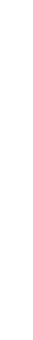

In [31]:
geoplot.choropleth(zone_shape, hue='SUPERFICIE')

In [32]:
#geoplot.choropleth(zone_shape, hue='name')

In [33]:
df_nearbyVenues.iloc[0,]

id                   584407c4c5f8a71c825742e4
name                     Tommi's Burger Joint
categories                       Burger Joint
lat                                    41.909
lng                                   12.4568
neighborhood    Viale Guilio Cesare 193 - 195
distance [m]                             2778
Name: 0, dtype: object

In [34]:
m = folium.Map(location=[rome_latitude, rome_longitude])
#folium.Choropleth(geo_data=zone_shape, data=zone_shape.SUPERFICIE, columns=['SUPERFICIE'], fill_color='YlOrBr').add_to(m)

folium.Choropleth(geo_data=zone_shape, fill_color='YlGn',columns=['ZU','SUPERFICIE']).add_to(m)

for kpoint in range(len(df_nearbyVenues)):
    df_select = df_nearbyVenues.iloc[kpoint,]
    folium.Marker(        
        [df_select.lat,df_select.lng],
        radius=6,
        popup=df_select['name']).add_to(m)

m

In [35]:
zone_shape['Latitude'] = zone_shape.geometry.centroid.apply(lambda p: round(p.y,10)).astype(float)
zone_shape['Longitude'] = zone_shape.geometry.centroid.apply(lambda p: round(p.x,10)).astype(float)

In [36]:
type(df_nearbyVenues) 

pandas.core.frame.DataFrame

In [37]:
gdf_restaurant = gpd.GeoDataFrame(
    df_nearbyVenues, crs=4326, geometry=gpd.points_from_xy(x=df_nearbyVenues.lng, y=df_nearbyVenues.lat))

In [38]:
gdf_restaurant.head()

,id,name,categories,lat,lng,neighborhood,distance [m],geometry
0,584407c4c5f8a71c825742e4,Tommi's Burger Joint,Burger Joint,41.908955,12.456788,Viale Guilio Cesare 193 - 195,2778,POINT (12.45679 41.90895)
1,4fad7a5ae4b01d34f6c204a1,Kilo Restaurant,Burger Joint,41.918245,12.498625,"Via Tirso, 30 (Via Metauro)",3064,POINT (12.49862 41.91825)
2,4ba626a5f964a5205c3739e3,Hard Rock Cafe Rome,American Restaurant,41.906361,12.489744,Via Vittorio Veneto 62A/B,1557,POINT (12.48974 41.90636)
3,56116270498efc11cb984b91,Ted Burger&Lobster,Burger Joint,41.906188,12.463252,Via Terenzio,2170,POINT (12.46325 41.90619)
4,4fa9883fe4b027255a2c6c22,Knick Knack Yoda (Dal Papa),Sandwich Place,41.906534,12.456899,"Piazza Risorgimento, 11",2610,POINT (12.45690 41.90653)


In [39]:
gdf_restaurant.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
gdf_restaurant.head(2)

,id,name,categories,lat,lng,neighborhood,distance [m],geometry
0,584407c4c5f8a71c825742e4,Tommi's Burger Joint,Burger Joint,41.908955,12.456788,Viale Guilio Cesare 193 - 195,2778,POINT (12.45679 41.90895)
1,4fad7a5ae4b01d34f6c204a1,Kilo Restaurant,Burger Joint,41.918245,12.498625,"Via Tirso, 30 (Via Metauro)",3064,POINT (12.49862 41.91825)


In [41]:
zone_shape = zone_shape.to_crs("EPSG:4326")

In [42]:
pointInPolys = sjoin(gdf_restaurant, zone_shape, how='left')

In [43]:
pointInPolys.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            100 non-null    object  
 1   name          100 non-null    object  
 2   categories    100 non-null    object  
 3   lat           100 non-null    float64 
 4   lng           100 non-null    float64 
 5   neighborhood  100 non-null    object  
 6   distance [m]  100 non-null    int64   
 7   geometry      100 non-null    geometry
 8   index_right   89 non-null     float64 
 9   ZU            89 non-null     object  
 10  CODZU         89 non-null     object  
 11  MUNICIPIO     89 non-null     float64 
 12  GRA           89 non-null     float64 
 13  SUPERFICIE    89 non-null     float64 
 14  Latitude      89 non-null     float64 
 15  Longitude     89 non-null     float64 
dtypes: float64(8), geometry(1), int64(1), object(6)
memory usage: 13.3+ KB


In [44]:
ZUcounts = pointInPolys.groupby("CODZU").count()['name']

In [45]:
zone_shape.head()

,ZU,CODZU,MUNICIPIO,GRA,SUPERFICIE,geometry,Latitude,Longitude
0,Tuscolano Nord,9A,7.0,1.0,107.0,"POLYGON Z ((12.52509 41.88522 0.00000, 12.5255...",4.639915e+06,294128.185371
1,Tuscolano Sud,9B,7.0,1.0,316.0,"POLYGON Z ((12.52989 41.86369 0.00000, 12.5298...",4.638557e+06,295128.310369
2,Tor Fiscale,9C,7.0,1.0,91.0,"POLYGON Z ((12.53529 41.85882 0.00000, 12.5360...",4.636912e+06,296070.171613
3,Appio,9D,7.0,1.0,134.0,"POLYGON Z ((12.50904 41.87505 0.00000, 12.5088...",4.639340e+06,293175.552619
4,Latino,9E,7.0,1.0,159.0,"POLYGON Z ((12.50329 41.86663 0.00000, 12.5032...",4.638503e+06,293692.420074


In [46]:
ZUcounts.head()

CODZU
10G    2
10H    1
10L    1
11A    4
11C    1
Name: name, dtype: int64

In [47]:
zone_shape = zone_shape.merge(ZUcounts, left_on='CODZU', right_on='CODZU')

In [48]:
zone_shape.head()

,ZU,CODZU,MUNICIPIO,GRA,SUPERFICIE,geometry,Latitude,Longitude,name
0,Appio,9D,7.0,1.0,134.0,"POLYGON Z ((12.50904 41.87505 0.00000, 12.5088...",4.639340e+06,293175.552619,1
1,Latino,9E,7.0,1.0,159.0,"POLYGON Z ((12.50329 41.86663 0.00000, 12.5032...",4.638503e+06,293692.420074,1
2,Romanina,10G,7.0,0.0,221.0,"POLYGON Z ((12.60355 41.85092 0.00000, 12.6078...",4.635251e+06,300959.943652,2
3,Morena,10L,7.0,0.0,894.0,"POLYGON Z ((12.59914 41.82857 0.00000, 12.6028...",4.632170e+06,302177.644675,1
4,Gregna,10H,7.0,0.0,283.0,"POLYGON Z ((12.60837 41.83348 0.00000, 12.6087...",4.633730e+06,300356.485824,1


In [49]:
print(type(zone_shape))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [50]:
burger_select = zone_shape[['ZU','CODZU','name']].copy(deep=True)

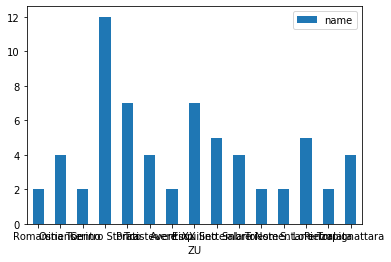

In [51]:
burger_select[burger_select.name > 1 ].plot.bar(x='ZU', y='name', rot=0)

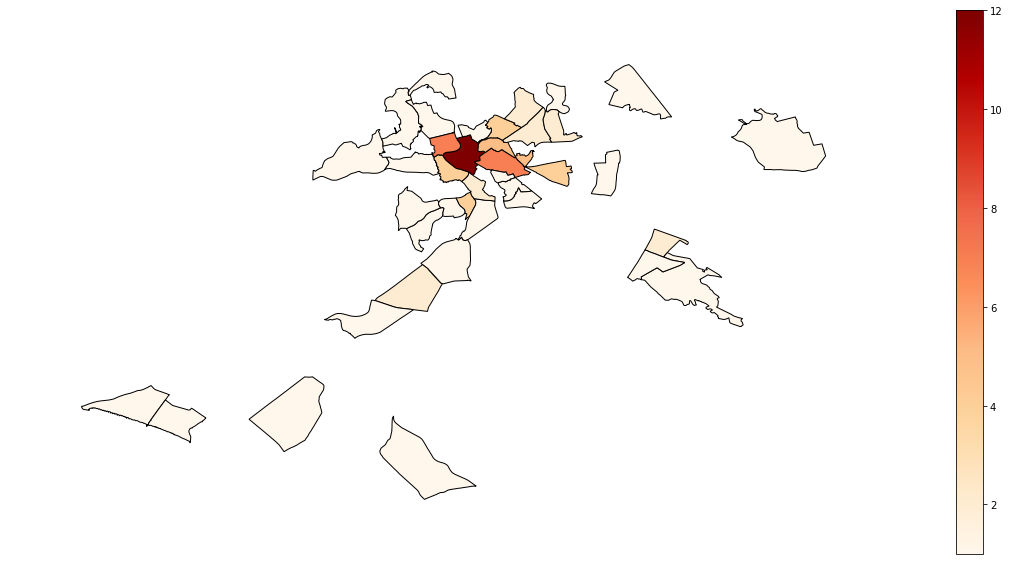

In [52]:
PALETTE = 'OrRd'
geoplot.choropleth(zone_shape, hue="name", legend=True, cmap = PALETTE, figsize = (20,10))

In [53]:
#PALETTE = 'OrRd'
#geoplot.choropleth(zone_shape, hue="name", legend=True, cmap = PALETTE, figsize = (20,10))
m2 = folium.Map(location=[rome_latitude, rome_longitude])
folium.Choropleth(geo_data=zone_shape, columns=['ZU','name'], data=zone_shape.name,fill_color='YlGn',bins=[0, 5, 10]).add_to(m2)
folium.map.LayerControl('topleft', collapsed=True).add_to(m2)
m2

In [54]:
gdf_restaurant

,id,name,categories,lat,lng,neighborhood,distance [m],geometry
0,584407c4c5f8a71c825742e4,Tommi's Burger Joint,Burger Joint,41.908955,12.456788,Viale Guilio Cesare 193 - 195,2778,POINT (12.45679 41.90895)
1,4fad7a5ae4b01d34f6c204a1,Kilo Restaurant,Burger Joint,41.918245,12.498625,"Via Tirso, 30 (Via Metauro)",3064,POINT (12.49862 41.91825)
2,4ba626a5f964a5205c3739e3,Hard Rock Cafe Rome,American Restaurant,41.906361,12.489744,Via Vittorio Veneto 62A/B,1557,POINT (12.48974 41.90636)
3,56116270498efc11cb984b91,Ted Burger&Lobster,Burger Joint,41.906188,12.463252,Via Terenzio,2170,POINT (12.46325 41.90619)
4,4fa9883fe4b027255a2c6c22,Knick Knack Yoda (Dal Papa),Sandwich Place,41.906534,12.456899,"Piazza Risorgimento, 11",2610,POINT (12.45690 41.90653)
5,51046072e4b0fcbbb0a4d447,Birretta - Wine and Food,Burger Joint,41.912490,12.456520,Via Simone de Saint Bon 69 - 71 (Via Costantin...,3056,POINT (12.45652 41.91249)
6,4eac72e5cc21b06a5733c8d2,Dolce,Burger Joint,41.930430,12.519660,"Via Tripolitania, 4 (Via Tripoli)",5130,POINT (12.51966 41.93043)
7,4f0ca841e4b0f615a3a98338,Rec23,Burger Joint,41.882607,12.476174,"Piazza dell'Emporio, 1-2 (Via Amerigo Vespucci)",1317,POINT (12.47617 41.88261)
8,55fc0a0f498ee968042dadb7,The Meat Market Rome,Burger Joint,41.900200,12.465325,"Corso Vittorio Emanuele II, 320",1647,POINT (12.46532 41.90020)
9,505cfe7fd63e507d9a737c37,Fonzie - The Burger's House,Burger Joint,41.893466,12.476194,Via Santa Maria del Pianto 13,558,POINT (12.47619 41.89347)


In [55]:
#https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe